In [13]:
import utils
import qiskit
import qiskit_aer
import numpy as np
from math import log
import qiskit.visualization
import matplotlib.pyplot as plt
from qiskit.circuit.library import XGate

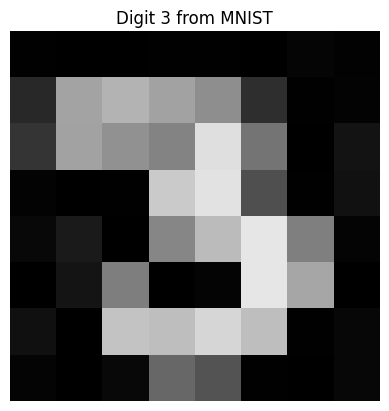

In [14]:
image = utils.plot_image('images/three_8by8.jpg', 'Digit 3 from MNIST')

In [15]:
def equal_superposition(circ: qiskit.QuantumCircuit, start: int, end: int):
    for idx in range(start, end): 
        circ.h(idx)
        
def iterate(circ: qiskit.QuantumCircuit, padding: int, current_state: str, next_state: str):
    n = len(current_state)
    
    # Indices we must apply an X gate to go from current_state to next_state 
    #   - We reverse the state strings because we set the coordinates qubits in the circuit
    #       in descending order.
    x_targets = np.array([idx + padding for idx in range(n) 
                          if current_state[::-1][idx] != next_state[::-1][idx]])

    # Example
    # 1110 -> 1111
    #   if we don't reverse the strings we get:
    #   x_targets = [3]
    #   thus we will apply the X gate on the fourth qubit.
    #   but this is not what we want, we should apply it to the first qubit.
    #   think little endian vs big endian
    
    if x_targets.size > 0:
        circ.x(x_targets)

def pixel_encoding(circ: qiskit.QuantumCircuit, control: list, intensity: str):
    for idx, val in enumerate(intensity[::-1]):
        if int(val):
            circ.mcx(control_qubits=control,
                     target_qubit=idx)
            
    

In [16]:
def construct_brqi(circ: qiskit.QuantumCircuit, image: np.array):
    # TEMP
    w_bits = int(np.ceil(log(image.shape[1], 2)))
    h_bits = int(np.ceil(log(image.shape[0], 2)))
    
    num_qubits = circ.num_qubits
    
    circ.h([*range(1, num_qubits)])
    circ.barrier()
    
    for bitplane in range(8):
        bin_bitplane = '{0:0{1}b}'.format(bitplane, 8)
        
        for idx, bit in enumerate(bin_bitplane):
            if not int(bit):
                circ.x(idx)
                
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                pixel_val = '{0:0{1}b}'.format(image[i, j], 8)
                
                if int(pixel_val[bitplane]):
                    i_bit = '{0:0{1}b}'.format(i, h_bits)
                    
                    for i_n, ibit in enumerate(i_bit):
                        if not int(ibit):
                            circ.x(1 + h_bits + i_n)
                        
                        j_bit = "{0:b}".format(j).zfill(w_bits)
                    for j_n, jbit in enumerate(j_bit):
                        if jbit!='1':
                            circ.x(1+ j_n)
                    circ.barrier()
                    controls = list(range(1, num_qubits))
                    xg = XGate(None).control(len(controls))
                    controls.append(1)
                    circ.append(xg, controls)

                    for j_n, jbit in enumerate(j_bit):
                        if jbit!='1':
                            circ.x(1 +j_n )

                    for i_n, ibit in enumerate(i_bit):
                            if ibit!='1':
                                circ.x(1 + h_bits + i_n)
                    circ.barrier()

        for idx, bit in enumerate(bin_bitplane):
            if not int(bit):
                circ.x(1 + 8 + idx -1)
    circ.barrier()
    
    to_measure = [*range(num_qubits)]
    
    circ.measure(to_measure, to_measure)

In [17]:
w_bits = int(np.ceil(log(image.shape[1], 2)))
h_bits = int(np.ceil(log(image.shape[0], 2)))
color_n_b = int(np.ceil(log(8, 2)))

n = int(log(image.shape[0], 2))

color_reg = qiskit.QuantumRegister(1, 'Color')
ys_reg = qiskit.QuantumRegister(w_bits, 'Y axis')
xs_reg = qiskit.QuantumRegister(h_bits, 'X axis')
bitplane_reg = qiskit.QuantumRegister(color_n_b, 'Bitplanes')
creg = qiskit.ClassicalRegister(1+w_bits+h_bits+color_n_b, 'Bits')

brqi_circuit = qiskit.QuantumCircuit(color_reg, ys_reg, xs_reg, bitplane_reg, creg)

In [18]:
construct_brqi(brqi_circuit,  image)
brqi_circuit.draw(output='mpl')

CircuitError: 'duplicate qubit arguments'